#  Прогнозирование заказов такси

Агрегатор такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Необходимо:

- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot
import warnings
warnings.filterwarnings("ignore")

In [2]:
taxi = pd.read_csv('taxi.csv')

In [3]:
taxi

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

In [6]:
taxi = taxi.set_index('datetime')

In [7]:
taxi.index.is_monotonic

True

## Анализ

In [8]:
taxi = taxi.resample('1H').sum()

In [9]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [10]:
decomposed_taxi = seasonal_decompose(taxi)

<AxesSubplot:xlabel='datetime'>

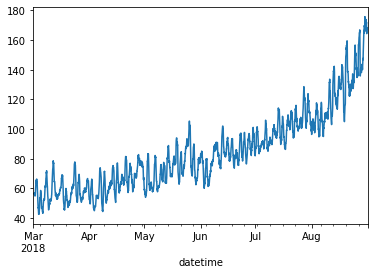

In [11]:
decomposed_taxi.trend.plot(ax = plt.gca())

Тренд - увеличение заказов к сентябрю.

<AxesSubplot:xlabel='datetime'>

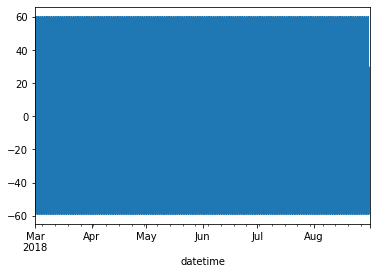

In [12]:
decomposed_taxi.seasonal.plot(ax = plt.gca())

В масштабе всего датафрейма сезонность проследить не удается. Увеньшим датафрейм до размеров 5 дней

<AxesSubplot:xlabel='datetime'>

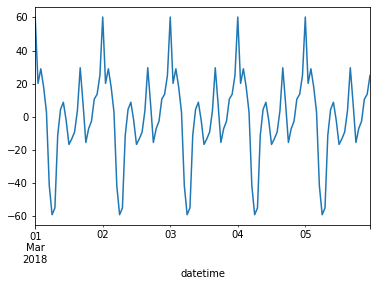

In [13]:
decomposed_taxi.seasonal.head(120).plot(ax = plt.gca())

Количество заказов падает ночью и рано утром и поднимается днем и вечером.

<AxesSubplot:xlabel='datetime'>

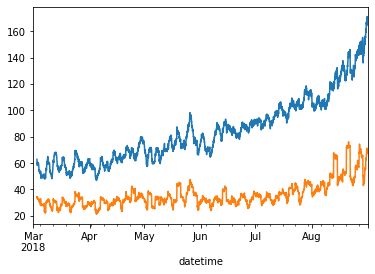

In [14]:
taxi['mean'] = taxi['num_orders'].rolling(50).mean()
taxi['std'] = taxi['num_orders'].rolling(50).std()
taxi['mean'].plot()
taxi['std'].plot()

## Обучение

In [15]:
taxi = taxi.drop('std', axis = 1)
taxi = taxi.drop('mean', axis = 1)

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    train, test = train_test_split(data_new, test_size = 0.1, shuffle = False)
    return(train, test)

Обучим линейную регрессию и подберем лучшее значение "отстающих" значений и скользящего среднего.

In [17]:
best_result_cv = 1000000
for i in range(1, 106, 5):
    train, test = make_features(taxi, i, i)
    train = train.dropna()
    features_train = train.drop(['num_orders'], axis = 1)
    target_train = train['num_orders']
    features_test = test.drop(['num_orders'], axis = 1)
    target_test = test['num_orders']
    model = LinearRegression()
    model.fit(features_train, target_train)
    my_cv = TimeSeriesSplit(n_splits = 3)
    cv_score = cross_val_score(model, features_train, target_train, cv = my_cv, scoring = 'neg_mean_squared_error')
    cv_score_final = sum(cv_score) / len(cv_score)
    result_cv = abs(cv_score_final) ** 0.5
    if result_cv < best_result_cv:
        best_result_cv = result_cv
        best_parameters_cv = i
print('Лучший результат RMSE на кросс-валидации: ', best_result_cv)
print('Лучшее значение "отстающих" значений и скользящего среднего на тренировочной выборке: ', best_parameters_cv)

Лучший результат RMSE на кросс-валидации:  24.888615078278132
Лучшее значение "отстающих" значений и скользящего среднего на тренировочной выборке:  96


Лучшее значение RMSE достигается на максимальных значениях "отстающих" значений и скользящего среднего = 96. Оставим эти значения, найдем значение rmse на тесовой выборке и обучим "Случайный лес".

In [18]:
train, test = make_features(taxi, 96, 96)
train = train.dropna()
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
best_result_test = mean_squared_error(predictions_test, target_test) ** 0.5
best_result_test

41.595545550249355

In [19]:
params = {
    'n_estimators' : [70, 100],
    'max_depth' : [1, 5, 20]
}

In [20]:
grid = GridSearchCV(RandomForestRegressor(random_state = 12345), params, scoring='neg_mean_squared_error', cv=3)
RandomForestRegressor_best_result = grid.fit(features_train, target_train)

In [21]:
RandomForestRegressor_best_result = grid.best_estimator_
RandomForestRegressor_best_result

RandomForestRegressor(max_depth=20, n_estimators=70, random_state=12345)

In [22]:
predictions_RandomForestRegressor = RandomForestRegressor_best_result.predict(features_test)

In [23]:
rmse_test_RandomForestRegressor = mean_squared_error(target_test, predictions_RandomForestRegressor) ** 0.5
print('Результат RMSE на тестовой выборке: ', rmse_test_RandomForestRegressor)

Результат RMSE на тестовой выборке:  40.285953566860286


## Выводы

In [24]:
result = pd.DataFrame({'Линейная регрессия' : [best_result_test],
                      'Случайный лес' : [rmse_test_RandomForestRegressor],
                      'Метрика' : 'rmse'})
result = result.set_index('Метрика')

In [25]:
result

,Линейная регрессия,Случайный лес
Метрика,,
rmse,41.595546,40.285954


In [26]:
test_results = test.copy()
test_results = test_results.drop(test_results[list(test_results.columns[1:])], axis = 1)
test_results['predictions_test_linear_reg'] = predictions_test.round().astype(int)
test_results['predictions_test_random_forest'] = predictions_RandomForestRegressor.round().astype(int)
test_results

,num_orders,predictions_test_linear_reg,predictions_test_random_forest
datetime,,,
2018-08-13 14:00:00,102,122,96
2018-08-13 15:00:00,175,131,126
2018-08-13 16:00:00,144,158,159
2018-08-13 17:00:00,152,125,142
2018-08-13 18:00:00,104,101,105
...,...,...,...
2018-08-31 19:00:00,136,110,171
2018-08-31 20:00:00,154,132,148
2018-08-31 21:00:00,159,167,164


<AxesSubplot:xlabel='datetime'>

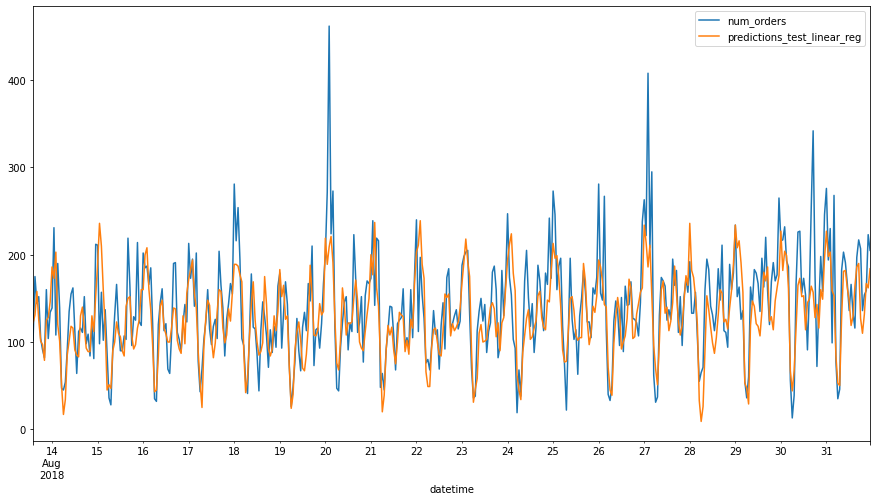

In [27]:
test_results[['num_orders', 'predictions_test_linear_reg']].plot(figsize = (15, 8))

<AxesSubplot:xlabel='datetime'>

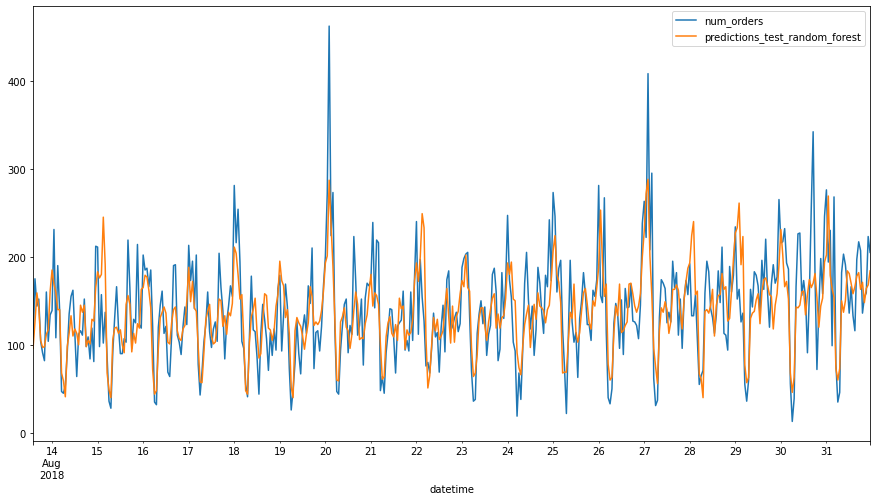

In [28]:
test_results[['num_orders', 'predictions_test_random_forest']].plot(figsize = (15, 8))

Лучшее значение rmse достигатся на значениях "отстающих" значений и скользящего среднего = 96. При этих параметрах лучшее значение RMSE достигается на модели "Случайный лес" - 40.285954. На графике результатов видно, что модели хорошо предсказывают время наступления пиковых значений, однако при сильных пиках реальных данных модели дают более усредненный ответ, чем ожидается.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48